In [2]:
import io
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()
ratings = pd.read_csv(io.BytesIO(uploaded['ratings_small.csv']))
ratings.head()

Saving ratings_small.csv to ratings_small.csv


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [4]:
ratings.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [5]:
ratings.applymap(type)

,userId,movieId,rating,timestamp
0,<class 'int'>,<class 'int'>,<class 'float'>,<class 'int'>
1,<class 'int'>,<class 'int'>,<class 'float'>,<class 'int'>
2,<class 'int'>,<class 'int'>,<class 'float'>,<class 'int'>
3,<class 'int'>,<class 'int'>,<class 'float'>,<class 'int'>
4,<class 'int'>,<class 'int'>,<class 'float'>,<class 'int'>
...,...,...,...,...
99999,<class 'int'>,<class 'int'>,<class 'float'>,<class 'int'>
100000,<class 'int'>,<class 'int'>,<class 'float'>,<class 'int'>
100001,<class 'int'>,<class 'int'>,<class 'float'>,<class 'int'>
100002,<class 'int'>,<class 'int'>,<class 'float'>,<class 'int'>


In [6]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (80003, 4)
Shape of test data: (20001, 4)


In [7]:
import tensorflow as tf
from tensorflow import keras

#Movie input network
nmovieId = ratings['movieId'].count()
input_movies = tf.keras.layers.Input(shape=[1])
embed_movies = tf.keras.layers.Embedding(nmovieId + 1,15)(input_movies)
movies_out = tf.keras.layers.Flatten()(embed_movies)

#user input network
nuserId = ratings['userId'].count()
input_users = tf.keras.layers.Input(shape=[1])
embed_users = tf.keras.layers.Embedding(nuserId + 1,15)(input_users)
users_out = tf.keras.layers.Flatten()(embed_users)

conc_layer = tf.keras.layers.Concatenate()([movies_out, users_out])
x = tf.keras.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.keras.layers.Dense(1, activation='relu')(x)
model = tf.keras.Model([input_movies, input_users], x_out)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [8]:
Xtest['rating']

99778    4.0
16170    3.5
3521     5.0
55070    5.0
25477    3.0
        ... 
5994     4.0
11605    4.0
73509    3.0
25812    5.0
3529     2.5
Name: rating, Length: 20001, dtype: float64

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


# Split the data into train and test sets
X = ratings[['movieId', 'userId']]
y = ratings['rating']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

# Mapping movie and user IDs to indices
movie_to_index = {mid: i for i, mid in enumerate(ratings['movieId'].unique())}
user_to_index = {uid: i for i, uid in enumerate(ratings['userId'].unique())}

# Convert IDs to indices
Xtrain['movie_index'] = Xtrain['movieId'].map(movie_to_index)
Xtrain['user_index'] = Xtrain['userId'].map(user_to_index)

Xtest['movie_index'] = Xtest['movieId'].map(movie_to_index)
Xtest['user_index'] = Xtest['userId'].map(user_to_index)

# Convert data to numpy arrays
movie_train = np.array(Xtrain['movie_index'])
user_train = np.array(Xtrain['user_index'])
rating_train = np.array(ytrain)

movie_test = np.array(Xtest['movie_index'])
user_test = np.array(Xtest['user_index'])
rating_test = np.array(ytest)

# Number of unique movies and users
nmovieId = ratings['movieId'].nunique()
nuserId = ratings['userId'].nunique()

# Movie input network
input_movies = tf.keras.layers.Input(shape=[1])
embed_movies = tf.keras.layers.Embedding(nmovieId + 1, 15)(input_movies)
movies_out = tf.keras.layers.Flatten()(embed_movies)

# User input network
input_users = tf.keras.layers.Input(shape=[1])
embed_users = tf.keras.layers.Embedding(nuserId + 1, 15)(input_users)
users_out = tf.keras.layers.Flatten()(embed_users)

# Concatenate the movie and user layers
conc_layer = tf.keras.layers.Concatenate()([movies_out, users_out])

# Add a dense layer
x = tf.keras.layers.Dense(128, activation='relu')(conc_layer)
x_out = tf.keras.layers.Dense(1, activation='relu')(x)

# Define the model with the inputs and output
model = tf.keras.Model([input_movies, input_users], x_out)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit the model with the data
hist = model.fit([movie_train, user_train], rating_train,
                 batch_size=64,
                 epochs=5,
                 verbose=1,
                 validation_data=([movie_test, user_test], rating_test))

Epoch 1/5
1251/1251 [==============================] - 8s 6ms/step - loss: 1.4687 - val_loss: 0.8126
Epoch 2/5
1251/1251 [==============================] - 5s 4ms/step - loss: 0.7583 - val_loss: 0.7923
Epoch 3/5
1251/1251 [==============================] - 5s 4ms/step - loss: 0.7173 - val_loss: 0.7929
Epoch 4/5
1251/1251 [==============================] - 7s 5ms/step - loss: 0.6897 - val_loss: 0.7949
Epoch 5/5
1251/1251 [==============================] - 5s 4ms/step - loss: 0.6676 - val_loss: 0.7804


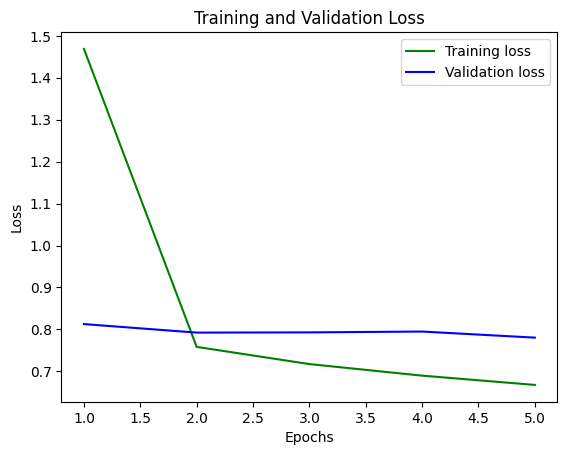

In [10]:
import matplotlib.pyplot as plt

# Get the training and validation loss values from the history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 15)                136005    ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 15)                10080     ['input_4[0][0]']             
                                                                                            

In [54]:
embedding_layer_name = 'embedding_2'

# Access the embedding layer using get_layer
movie_embedding_layer = model.get_layer(embedding_layer_name)

# Get the weights from the embedding layer
movie_weights = movie_embedding_layer.get_weights()[0]

print(f"Shape of movie embedding weights: {movie_weights.shape}")

Shape of movie embedding weights: (9067, 15)


In [12]:
import io
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()
movies_df = pd.read_csv(io.BytesIO(uploaded['movies_metadata.csv']))
movies_df.head()

Saving movies_metadata.csv to movies_metadata.csv


<ipython-input-12-fd39a81423e0>:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv(io.BytesIO(uploaded['movies_metadata.csv']))


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [13]:
m_id = list(ratings['movieId'].unique())
dict_map = {}

out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')

for i in m_id:
    try:
        movie = movies_df.loc[movies_df['id'] == i, 'title'].values[0]
        embeddings = movie_weights[i]
        out_m.write(movie + "\n")
        out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    except IndexError:
        print(f"Skipping movie ID {i} as it was not found or has no embeddings.")

out_v.close()
out_m.close()

Streaming output truncated to the last 5000 lines.
Skipping movie ID 117123 as it was not found or has no embeddings.
Skipping movie ID 118082 as it was not found or has no embeddings.
Skipping movie ID 126006 as it was not found or has no embeddings.
Skipping movie ID 130642 as it was not found or has no embeddings.
Skipping movie ID 130682 as it was not found or has no embeddings.
Skipping movie ID 135887 as it was not found or has no embeddings.
Skipping movie ID 139130 as it was not found or has no embeddings.
Skipping movie ID 141718 as it was not found or has no embeddings.
Skipping movie ID 141866 as it was not found or has no embeddings.
Skipping movie ID 152091 as it was not found or has no embeddings.
Skipping movie ID 152844 as it was not found or has no embeddings.
Skipping movie ID 156726 as it was not found or has no embeddings.
Skipping movie ID 159462 as it was not found or has no embeddings.
Skipping movie ID 161594 as it was not found or has no embeddings.
Skipping mo

In [20]:
m_id = list(ratings['movieId'].unique())
dict_map = {}

out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')

for i in m_id:
    try:
        movie = movies_df.loc[movies_df['id'] == i, 'title'].values[0]
        embeddings = movie_weights[i]
        out_m.write(movie + "\n")
        out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    except IndexError:
        print(f"Skipping movie ID {i} as it was not found or has no embeddings.")

out_v.close()
out_m.close()

Streaming output truncated to the last 5000 lines.
Skipping movie ID 117123 as it was not found or has no embeddings.
Skipping movie ID 118082 as it was not found or has no embeddings.
Skipping movie ID 126006 as it was not found or has no embeddings.
Skipping movie ID 130642 as it was not found or has no embeddings.
Skipping movie ID 130682 as it was not found or has no embeddings.
Skipping movie ID 135887 as it was not found or has no embeddings.
Skipping movie ID 139130 as it was not found or has no embeddings.
Skipping movie ID 141718 as it was not found or has no embeddings.
Skipping movie ID 141866 as it was not found or has no embeddings.
Skipping movie ID 152091 as it was not found or has no embeddings.
Skipping movie ID 152844 as it was not found or has no embeddings.
Skipping movie ID 156726 as it was not found or has no embeddings.
Skipping movie ID 159462 as it was not found or has no embeddings.
Skipping movie ID 161594 as it was not found or has no embeddings.
Skipping mo

In [ ]:
dict_map = {}

# Iterate through unique movie IDs
for movie_id in ratings['movieId'].unique():
    try:
        # Find the corresponding movie title in 'movies_df'
        movie_title = movies_df.loc[movies_df['id'] == movie_id, 'title'].values[0]

        # Map movie ID to movie title in the dictionary
        dict_map[movie_id] = movie_title
    except IndexError:
        # Handle the case where the movie ID is not found in 'movies_df'
        print(f"Skipping movie ID {movie_id} as it was not found.")

# Now, dict_map contains the mapping of movie indices to movie titles
print(dict_map)

Streaming output truncated to the last 5000 lines.
Skipping movie ID 2687 as it was not found.
Skipping movie ID 2688 as it was not found.
Skipping movie ID 2738 as it was not found.
Skipping movie ID 2741 as it was not found.
Skipping movie ID 2749 as it was not found.
Skipping movie ID 2750 as it was not found.
Skipping movie ID 2757 as it was not found.
Skipping movie ID 2782 as it was not found.
Skipping movie ID 2787 as it was not found.
Skipping movie ID 2790 as it was not found.
Skipping movie ID 2793 as it was not found.
Skipping movie ID 2794 as it was not found.
Skipping movie ID 2802 as it was not found.
Skipping movie ID 2829 as it was not found.
Skipping movie ID 2851 as it was not found.
Skipping movie ID 2852 as it was not found.
Skipping movie ID 2856 as it was not found.
Skipping movie ID 2875 as it was not found.
Skipping movie ID 2883 as it was not found.
Skipping movie ID 2917 as it was not found.
Skipping movie ID 2929 as it was not found.
Skipping movie ID 2944 as

In [15]:
num_movies_to_recommend = 10
movie_indices_to_recommend = np.arange(num_movies_to_recommend)


user_index_to_recommend = np.array([0] * num_movies_to_recommend)

# Make predictions
predicted_ratings = model.predict([movie_indices_to_recommend, user_index_to_recommend])

# Create a list of tuples (movie_index, predicted_rating)
movie_rating_tuples = list(zip(movie_indices_to_recommend, predicted_ratings.flatten()))

# Sort the list based on predicted ratings in descending order
sorted_movie_ratings = sorted(movie_rating_tuples, key=lambda x: x[1], reverse=True)

# Get the top N recommended movies
top_n_recommendations = sorted_movie_ratings[:num_movies_to_recommend]

# Print or use the recommended movies
for movie_index, predicted_rating in top_n_recommendations:
    movie_title = dict_map.get(movie_index, f"Unknown Movie {movie_index}")
    print(f"Recommended Movie: {movie_title}, Predicted Rating: {predicted_rating}")

1/1 [==============================] - 0s 109ms/step
Recommended Movie: Unknown Movie 4, Predicted Rating: 3.0801568031311035
Recommended Movie: Unknown Movie 9, Predicted Rating: 2.8435122966766357
Recommended Movie: Unknown Movie 7, Predicted Rating: 2.833012819290161
Recommended Movie: Unknown Movie 5, Predicted Rating: 2.7791433334350586
Recommended Movie: Unknown Movie 2, Predicted Rating: 2.6679837703704834
Recommended Movie: Unknown Movie 6, Predicted Rating: 2.6208581924438477
Recommended Movie: Unknown Movie 1, Predicted Rating: 2.5470664501190186
Recommended Movie: Unknown Movie 8, Predicted Rating: 2.3596463203430176
Recommended Movie: Unknown Movie 3, Predicted Rating: 2.2640249729156494
Recommended Movie: Unknown Movie 0, Predicted Rating: 2.0776968002319336


In [50]:
# Get all unique user IDs
all_user_ids = ratings['userId'].unique()

# Choose a random user ID
random_user_id = np.random.choice(all_user_ids)

# Get all unique movie IDs
all_movie_ids = ratings['movieId'].unique()

# Create an array with the randomly chosen user ID for all movies
user_id_for_all_movies = np.ones_like(all_movie_ids) * random_user_id

# Convert movie IDs to indices
movie_indices = np.array([movie_to_index[movie_id] for movie_id in all_movie_ids])

# Convert user ID to index
user_index = user_to_index[random_user_id]

# Predict ratings for all movies with the randomly chosen user
predicted_ratings = model.predict([movie_indices, np.full_like(movie_indices, user_index)])

# Print or use the predicted ratings as needed
#print(predicted_ratings)

predicted_df = pd.DataFrame({'MovieId': all_movie_ids, 'Predicted_Rating': predicted_ratings.flatten()})

# Map movie IDs to movie names
predicted_df['MovieName'] = predicted_df['MovieId'].map(dict_map)

# Handle cases where the movie ID is not found in 'dict_map'
predicted_df['MovieName'].fillna(f"Unknown Movie (ID {predicted_df['MovieId']})", inplace=True)

# Sort the DataFrame by predicted ratings in descending order
predicted_df = predicted_df.sort_values(by='Predicted_Rating', ascending=False)

# Display the top 10 predicted ratings along with movie names
top_10_predictions = predicted_df.head(10)[['MovieName', 'Predicted_Rating']]
print(top_10_predictions)

284/284 [==============================] - 0s 2ms/step
                                              MovieName  Predicted_Rating
3147  Unknown Movie (ID 0          31\n1        1029...          5.095014
4214  Unknown Movie (ID 0          31\n1        1029...          5.066086
2679  Unknown Movie (ID 0          31\n1        1029...          5.057333
4123  Unknown Movie (ID 0          31\n1        1029...          5.022809
5248  Unknown Movie (ID 0          31\n1        1029...          5.021346
4430  Unknown Movie (ID 0          31\n1        1029...          4.998896
1000  Unknown Movie (ID 0          31\n1        1029...          4.997824
2504  Unknown Movie (ID 0          31\n1        1029...          4.996023
2414  Unknown Movie (ID 0          31\n1        1029...          4.988422
4781  Unknown Movie (ID 0          31\n1        1029...          4.985120
